In [28]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [29]:
image = cv2.imread(r"C:\Users\markd\Documents\GitHub\ArticusMaximus\python_edge_detection\sample_images\cursed.jpg")
image = cv2.resize(image, (int(image.shape[1]/2), int(image.shape[0]/2)), interpolation=cv2.INTER_AREA)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [30]:
# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow("gray", gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
# Threshold
ret, thresh = cv2.threshold(gray, 100, 225, cv2.THRESH_BINARY)
cv2.imshow("threshold", thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [32]:
# Blur 
blur = cv2.GaussianBlur(gray, (5,5), sigmaX=0, sigmaY=0)
cv2.imshow("blur", blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
# Canny
canny = cv2.Canny(gray, 30, 200)
cv2.imshow("Canny", canny)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [34]:
# Canny w blur
canny_blur = cv2.Canny(blur, 30, 200)
cv2.imshow("Canny w blur", canny_blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [35]:
def perp_distance(pstart, pend, point):

    vectoru = np.array([point[0] - pstart[0], point[1] - pstart[1]])
    vectorv = np.array([pend[0] - pstart[0], pend[1] - pstart[1]])

    #finding  projection vector
    v_norm = np.sqrt(vectorv[0]**2 + vectorv[1]**2)
    proj_u_on_v = np.array([np.dot(vectoru, vectorv) / v_norm**2 * vectorv[0], np.dot(vectoru, vectorv) / v_norm**2 * vectorv[1]])

    #finding perpendicular vector
    perp_u_on_v = np.array([vectoru[0] - proj_u_on_v[0], vectoru[1] - proj_u_on_v[1]])

    return np.sqrt(perp_u_on_v[0]**2 + perp_u_on_v[1]**2)

def remove_duplicate_points(contour):
    i = 0
    num_deleted = 0
    while i  < contour.shape[0] - 1:
        if np.array_equal(contour[i - num_deleted], contour[i+1 - num_deleted]):
            contour = np.delete(contour, i - num_deleted, 0)
            print(f"point {i - num_deleted} deleted")
            print(contour)
            num_deleted += 1
        i += 1
    return contour
            

def Douglas_Peucker(points:np.array, epsilon:int):
    #max distance and index of the distance
    dmax = 0
    index = 0

    #for all points find distance and set dmax if largest
    for i, value in enumerate(points):
        distance = perp_distance(points[0], points[len(points)-1], points[i])
        if distance > dmax:
            dmax = distance
            index = i
    result_list = np.array([])

    #recursive algorithm
    if (dmax > epsilon):
        upper_recursive = Douglas_Peucker(points[0:index], epsilon)
        lower_recursive = Douglas_Peucker(points[index:len(points)], epsilon)
        
        #build resulting list
        result_list = np.concatenate((lower_recursive[0:(len(lower_recursive) - 1)], upper_recursive[0:len(upper_recursive - 1)]), axis=0)
    else:
        result_list = np.array([points[0], points[len(points)-1]])

    # return value
    return result_list

def remove_small_contours(contours:list, min_points_thresh:int):
    i = 0
    while i < len(contours):
        if contours[i].shape[0] <= min_points_thresh:
            contours.pop(i)
            print(f'{i} contour dropped')
        i += 1
    
    return contours

def remove_duplicate_contours(contours, match_thresh, pixel_thresh):
    # Checking contour pairs
    i = 0
    num_deleted = 0
    while(i < len(contours) - 1):
        # print(f'{ i } and {i + 1}: {cv2.matchShapes(contours[i], contours[i+1], cv2.CONTOURS_MATCH_I3,0)}')
        # print(f'{contours[i].mean()} and {contours[i+1].mean()}')
        match_score = cv2.matchShapes(contours[i - num_deleted], contours[i+1 - num_deleted], cv2.CONTOURS_MATCH_I3,0)
        # Remove contours with same shape in same location
        if match_score < match_thresh:
            mean_1 = contours[i - num_deleted].mean()
            mean_2 = contours[i+1 - num_deleted].mean()
            if (abs(mean_1 - mean_2) < pixel_thresh):
                contours.pop(i - num_deleted)
                # print("contour popped")
        i += 1
    
    return contours

point 0 deleted
[[337 380]]
point 0 deleted
[[285 173]]


C:\Users\markd\AppData\Local\Temp\ipykernel_33540\4167770365.py:8: RuntimeWarning: invalid value encountered in double_scalars
  proj_u_on_v = np.array([np.dot(vectoru, vectorv) / v_norm**2 * vectorv[0], np.dot(vectoru, vectorv) / v_norm**2 * vectorv[1]])


point 0 deleted
[[116  55]]
point 0 deleted
[[128  52]]
point 0 deleted
[[130  30]]
point 0 deleted
[[130  27]]
point 0 deleted
[[103   1]]
point 0 deleted
[[379   0]]
0 contour dropped
13 contour dropped
34 contour dropped
35 contour dropped
36 contour dropped
39 contour dropped


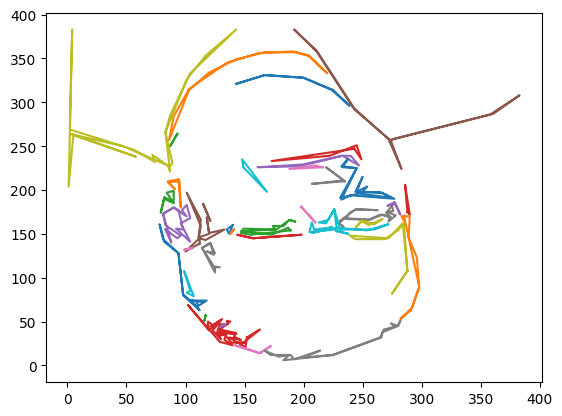

In [39]:
# Find contours from canny blurred image
contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)

# Epsilon value for Douglas Peucker algorithm, bigger == less details
epsilon = 3

# Filter out small contours and duplicate contours
contours = list(contours)
contours = remove_small_contours(contours, 2)
contours = remove_duplicate_contours(contours, 0.05, 10)

# Simpifly all contours
i = 0
while (i < len(contours)):
    # Contours is in [[],] shape, squeeze to simplify 
    contours[i] = np.squeeze(contours[i])
    # Remove any two points that are the same & next to each other
    contours[i] = remove_duplicate_points(contours[i])
    # Douglas Peucker Algorithm
    contours[i] = Douglas_Peucker(contours[i], epsilon)
    # Close contour (connect back to starting point)
    contours[i][-1] = contours[i][0]
    # Remove any duplicates resulting from Douglas Peucker
    contours[i] = remove_duplicate_points(contours[i])
    i += 1

# Filter again after simplifying 
contours = remove_small_contours(contours, 2)
contours = remove_duplicate_contours(contours, 0.05, 10)

# Display results 
for i in range(len(contours)):
    # plt.xlim(400)
    # plt.ylim(400)
    plt.plot(contours[i][:,0], contours[i][:,1], label=f'{i}')
plt.show()

# Write contours to file
f = open("contour_output.txt", 'w')
k = 0
for contour in contours:
    f.write(f'CONTOUR_{k} {str(contour.shape[0])}\n')
    k += 1
    for i in range(len(contour)):
        if i == 0:
            f.write("M ")
        else:
            f.write("D ")
        f.write(str(contour[i, 0]))
        f.write(" ")
        f.write(str(contour[i, 1]))
        f.write(" \n")

f.close()


In [37]:
contour.shape

(1, 2)

In [38]:
type(contours[0])

numpy.ndarray